## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
clone_changes_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/clone_change.csv"

outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_changes/de/minPct_0.01__logfc0.1_pthresh_0.01"
sample_names = "preB,postB"

# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

top_de = 3
logfcthresh=0.1
minPct = 0.01
p_thresh=0.01

In [2]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir)
donor.outdir <- file.path(outdir, "sepDonors")
dir.create(donor.outdir)

all.donor.outdir <- file.path(outdir, "allDonors")
dir.create(all.donor.outdir)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in dir.create(outdir):
“'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_changes/de/minPct_0.01__logfc0.1_pthresh_0.01' already exists”
Warning message in dir.create(donor.outdir):
“'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_changes/de/minPct_0.01__logfc0.1_pthresh_0.01/sepDonors' already exists”
Warning message in dir.create(all.donor.outdir):
“'

In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
61893 features across 4112 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Load clone_changes

In [6]:
clone_changes_f

[1] "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/clone_change.csv"

In [7]:
clone_changes <- read.csv(clone_changes_f)
row.names(clone_changes) <-clone_changes$name

In [8]:
clone_changes[c("name","change")]

,name,change
,<chr>,<chr>
2_10,2_10,regress
3_5,3_5,expand
3_11,3_11,expand
3_1,3_1,no_change
1_23,1_23,no_change
1_13,1_13,no_change
3_12,3_12,no_change
3_13,3_13,no_change
0_32,0_32,no_change


## Subset clones

### Add change col metadata for each clone
a) subset se by clone names
b) need to map each cell based on the clone value, create a dataframe. should be same number rows as se

In [9]:
se.filt <- subset(se , subset = name %in% clone_changes$name)
se.filt = subset(se.filt , subset = (name != "None"))

In [10]:
meta <- se.filt[[]]
meta$change <- NA
for (cell in row.names(meta)){
    curr <- clone_changes[as.character(meta[cell, "name"]),"change"]
    print(curr)
    if(is.na(curr)){
        break
    }
    meta[cell, "change"] = curr
}

se.filt <- AddMetaData(se.filt, meta[["change"]], col.name="change")


[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_ch

In [11]:
se.filt$change.stim <- paste(se.filt$change, se.filt$orig.ident, sep = "_")
#clone.ids <- sort(unique(se$name))
#se$clone <- se$name

Idents(se.filt) <- "change"



In [12]:
# run.de <- function(p){
#     ident.1 = p[[1]] # paste0(curr.clone, "_", sample_names[[1]]) 
#     ident.2 = p[[2]] #paste0(curr.clone, "_", sample_names[[2]])

#     curr.name <- paste("donor", curr.d, ident.1, "vs", ident.2, sep="_")
#     curr.dir <- paste0("donor", "_", curr.d)
#     curr.outdir <- file.path(donor.outdir, curr.dir)
#     dir.create(curr.outdir)

#     ## Run DE
#     curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
#                                       curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
#                                       min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
#     return(curr.sig)
    
# }

## a) For each donor, de for expanded vs regressed vs no change

In [13]:
donors <- sort(unique(se.filt$donor))
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()
for (curr.d in donors){
    print(paste0("donor ", curr.d))
    curr.se <- subset(se.filt, subset = donor == curr.d)
    changes <- unique(curr.se$change)
    if (length(changes)<2){
        print("Only one type of change for clone in this donor")
        print(changes)
        next
    }
    pairs <- combn(changes, 2)
    #curr.sigs <- lapply(pairs, 2, run.de)
    
    for (p in 1:ncol(pairs)){
        pair <- pairs[,p]
        ident.1 = pair[[1]] # paste0(curr.clone, "_", sample_names[[1]]) 
        ident.2 = pair[[2]] #paste0(curr.clone, "_", sample_names[[2]])

        curr.name <- paste("donor", curr.d, ident.1, "vs", ident.2, sep="_")
        #curr.dir <- paste0("donor", "_", curr.d)
        #curr.outdir <- file.path(donor.outdir, curr.dir)
        curr.outdir <- donor.outdir
        #dir.create(curr.outdir)

        ## Run DE
        curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                          curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        #curr.sig <- run.de(p)
        
        # Add DE to global results
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
    
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

[1] "donor 0"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "donor 1"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "donor 2"
[1] "Only one type of change for clone in this donor"
[1] "regress"
[1] "donor 3"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 1941 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1106    6
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 


## Donor separately

[1] "no_change" "regress"   "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 3069 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CRYAA   7.118011e-32 -0.1387596 0.000 0.091 1.393351e-27 6.342860e-28
GOLGA6B 1.503965e-16 -0.1440849 0.001 0.091 2.944011e-12 6.700915e-13
OR1L1   1.888163e-13 -0.1431507 0.001 0.091 3.696080e-09 5.608474e-10
OR10C1  2.101464e-11 -0.1369058 0.002 0.091 4.113616e-07 4.681537e-08
PRAMEF1 6.318983e-10 -0.2193407 0.002 0.091 1.236941e-05 9.888140e-07
NAT8    6.657933e-10 -0.2139290 0.002 0.091 1.303290e-05 9.888140e-07
[1] "dim response"
[1] 8911    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 3200 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
STK31 4.823066e-06   -0.16054 0.088 0.197 0.09441151  0.005194442
[1] "dim response"
[1] 1077    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 153 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
HDC   1.512959e-08  0.3788781 0.364 0.014 0.0002961617 0.0001380424
ASB16 3.776410e-07  0.1048530 0.182 0.000 0.0073923227 0.0017227983
[1] "dim response"
[1] 9124    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



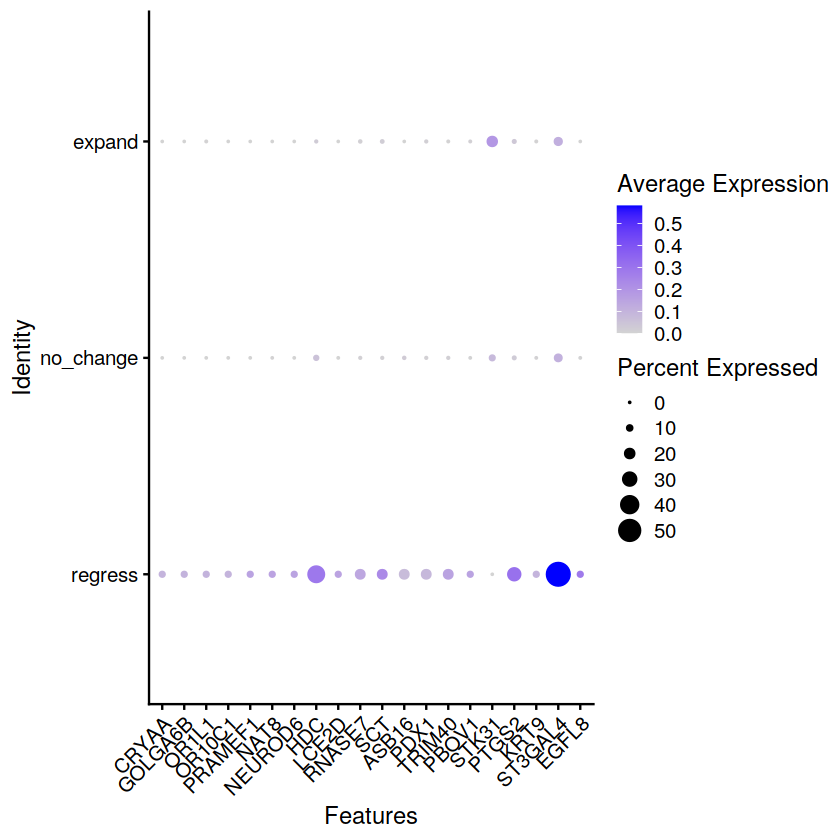

In [14]:
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()

curr.se <- se.filt
changes <- unique(curr.se$change)
print(changes)

if (length(changes)<2){
    print("Only one type of change for clone in this donor")
}else{
    pairs <- combn(changes, 2)
    #curr.sigs <- lapply(pairs, 2, run.de)  
    for (p in 1:ncol(pairs)){
        pair <- pairs[,p]
        ident.1 = pair[[1]] # paste0(curr.clone, "_", sample_names[[1]]) 
        ident.2 = pair[[2]] #paste0(curr.clone, "_", sample_names[[2]])

        curr.name <- paste(ident.1, "vs", ident.2, sep="_")
        curr.outdir <- all.donor.outdir #file.path(donor.outdir, curr.dir)

        ## Run DE
        curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                          curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        #curr.sig <- run.de(p)
        
        # Add DE to global results
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
    
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, all.donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(all.donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(all.donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(all.donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(all.donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

## b) For each donor, group by cluster, and run DE for expanded vs regressed vs no change, 

In [15]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [16]:
outdir

[1] "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_changes/de/minPct_0.01__logfc0.1_pthresh_0.01"